In [1]:
import matplotlib.pyplot as plt


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [285]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF
import seaborn as sns
import polars as pl
import numpy as np

from case_edits.ezcase import *
from helpers.helpers import *
from helpers.variables import *
from helpers.variable_interfaces import *
from setup.setup import *
from setup.plots import *
from setup.data_wrangle import *
from network.data_on_network import *

import matplotlib.cm as cm
import matplotlib as mpl


from matplotlib.colors import Colormap, Normalize, LinearSegmentedColormap
from setup.setup import create_directories

from helpers.ep_helpers import *
from subsurfaces.creator import SubsurfaceCreator
from airflow_network.airboundary import *
from subsurfaces.logic import find_surface_connecting_two_zones
from setup.analysis_air_boundary import *


In [284]:
all_variables.zone.temp


{'zone_mean_air_temp': 'Zone Mean Air Temperature'}

In [184]:
# create_cases(AIRBOUNDARY_FOLDER)



qois = get_qois()
cases = retrieve_cases(AIRBOUNDARY_FOLDER)
sc = cases[0]
sc

CaseData(case_name='amb_b1', idf=<geomeppy.idf.IDF object at 0x16bfc7280>, sql=Energy SQLiteResult: /Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/airboundary/case_amb_b1/results/eplusout.sql, path_to_input=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/svg2plan/outputs2/case_amb_b1'), path_to_output=PosixPath('/Users/julietnwagwuume-ezeoke/_UILCode/gqe-phd/geomeppy/cases/airboundary/case_amb_b1'))

In [281]:
df = get_df_many(cases)
df

case_names,space_names,qoi,values,datetimes,qoi_0,values_0
str,str,str,f64,datetime[μs],str,f64
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.061249,2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.147097
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.091203,2017-07-01 00:15:00,"""AFN Linkage Node 2 to Node 1 V…",0.154256
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.111956,2017-07-01 00:30:00,"""AFN Linkage Node 2 to Node 1 V…",0.138311
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.13722,2017-07-01 00:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.135198
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.128805,2017-07-01 01:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.125503
…,…,…,…,…,…,…
"""red_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.123359,2017-07-01 22:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.197759
"""red_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.149845,2017-07-01 23:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.226608
"""red_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.124116,2017-07-01 23:15:00,"""AFN Linkage Node 2 to Node 1 V…",0.191437


In [292]:
df_link = df.with_columns(linkage=pl.col("values") - pl.col("values_0"))
df_link

case_names,space_names,qoi,values,datetimes,qoi_0,values_0,linkage
str,str,str,f64,datetime[μs],str,f64,f64
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.061249,2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.147097,-0.085848
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.091203,2017-07-01 00:15:00,"""AFN Linkage Node 2 to Node 1 V…",0.154256,-0.063053
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.111956,2017-07-01 00:30:00,"""AFN Linkage Node 2 to Node 1 V…",0.138311,-0.026356
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.13722,2017-07-01 00:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.135198,0.002023
"""amb_b1""","""BLOCK 010 STOREY 0 WALL 0002_2…","""AFN Linkage Node 1 to Node 2 V…",0.128805,2017-07-01 01:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.125503,0.003302
…,…,…,…,…,…,…,…
"""red_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.123359,2017-07-01 22:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.197759,-0.0744
"""red_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.149845,2017-07-01 23:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.226608,-0.076763
"""red_b1""","""BLOCK 08 STOREY 0 WALL 0002_1""","""AFN Linkage Node 1 to Node 2 V…",0.124116,2017-07-01 23:15:00,"""AFN Linkage Node 2 to Node 1 V…",0.191437,-0.067321


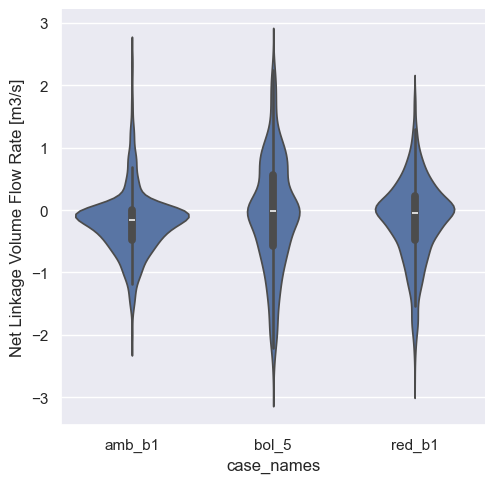

In [295]:
g = sns.catplot(data=df_link, x="case_names", y="linkage", kind="violin")
_, qoi_info = get_plot_labels(cases[0], df["qoi"][0], custom_qoi="Net Linkage Volume Flow Rate")
g.set_ylabels(qoi_info)

In [287]:
df2 = get_zone_df_many(cases)
df2

case_names,space_names,qoi,values,datetimes,qoi_0,values_0
str,str,str,f64,datetime[μs],str,f64
"""amb_b1""","""BLOCK 00 STOREY 0""","""Zone Mean Air Temperature""",20.294237,2017-07-01 00:00:00,"""AFN Zone Ventilation Air Chang…",40.98761
"""amb_b1""","""BLOCK 00 STOREY 0""","""Zone Mean Air Temperature""",19.65716,2017-07-01 00:15:00,"""AFN Zone Ventilation Air Chang…",39.001607
"""amb_b1""","""BLOCK 00 STOREY 0""","""Zone Mean Air Temperature""",19.062418,2017-07-01 00:30:00,"""AFN Zone Ventilation Air Chang…",38.440636
"""amb_b1""","""BLOCK 00 STOREY 0""","""Zone Mean Air Temperature""",18.506943,2017-07-01 00:45:00,"""AFN Zone Ventilation Air Chang…",38.34678
"""amb_b1""","""BLOCK 00 STOREY 0""","""Zone Mean Air Temperature""",18.200911,2017-07-01 01:00:00,"""AFN Zone Ventilation Air Chang…",35.53881
…,…,…,…,…,…,…
"""red_b1""","""BLOCK 09 STOREY 0""","""Zone Mean Air Temperature""",20.907621,2017-07-01 22:45:00,"""AFN Zone Ventilation Air Chang…",125.723891
"""red_b1""","""BLOCK 09 STOREY 0""","""Zone Mean Air Temperature""",20.857534,2017-07-01 23:00:00,"""AFN Zone Ventilation Air Chang…",120.414236
"""red_b1""","""BLOCK 09 STOREY 0""","""Zone Mean Air Temperature""",20.658013,2017-07-01 23:15:00,"""AFN Zone Ventilation Air Chang…",115.126108


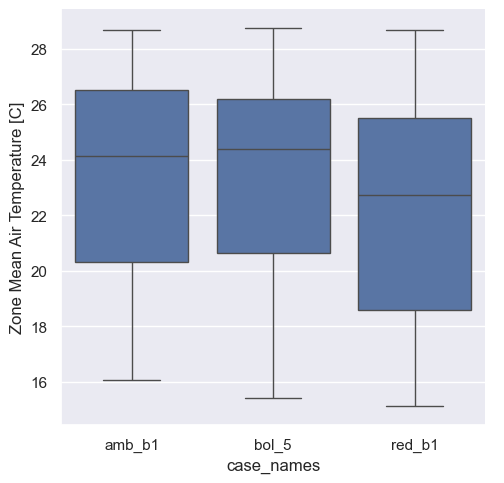

In [297]:
g = sns.catplot(data=df2, x="case_names", y="values", kind="box")
_, qoi_info = get_plot_labels(cases[0], df2["qoi"][0])
g.set_ylabels(qoi_info)

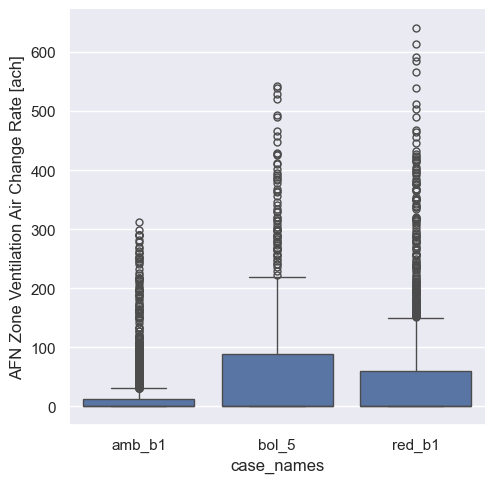

In [290]:
g = sns.catplot(data=df2, x="case_names", y="values_0", kind="box")
_, qoi_info = get_plot_labels(cases[0], df2["qoi_0"][0])
g.set_ylabels(qoi_info)